In [1]:
import numpy as np
import scipy as scipy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from neurolib.models.wc import WCModel

In [57]:
K_gl = 0.6
tau_exc = 2.5  # excitatory time constant
tau_inh = 3.75  # inhibitory time constant
c_excexc = 16  # local E-E coupling
c_excinh = 15  # local E-I coupling
c_inhexc = 12  # local I-E coupling
c_inhinh = 3  # local I-I coupling
a = 1.5  # excitatory gain
mu = 3.0  # excitatory firing threshold

def SE(x):
    return 1./(1. + np.exp(-a*(x-mu)))

def d_SE(x):
    return a*np.exp(-a*(x-mu))/(1. + np.exp(-a*(x-mu)))**2

def WC2N(x, *args):
    Eext, Iext = args
    E0dot = (-x[0] + (1. - x[0]) * SE(c_excexc*x[0] - c_inhexc*x[1] + K_gl*x[2] + Eext))/tau_exc
    I0dot = (-x[1] + (1. - x[1]) * SE(c_excinh*x[0] - c_inhinh*x[1] + Iext))/tau_inh
    E1dot = (-x[2] + (1. - x[2]) * SE(c_excexc*x[2] - c_inhexc*x[3] + K_gl*x[0] + Eext))/tau_exc
    I1dot = (-x[3] + (1. - x[3]) * SE(c_excinh*x[2] - c_inhinh*x[3] + Iext))/tau_inh

    return np.array([E0dot, I0dot, E1dot, I1dot])

def Jacobian(x, *args):
    Eext, Iext = args
    jac = np.zeros((4,4))

    x0E = c_excexc*x[0] - c_inhexc*x[1] + K_gl*x[2] + Eext
    jac[0,0] = (-1. - SE(x0E) + (1. - x[0])*d_SE(x0E)*c_excexc)/tau_exc
    jac[0,1] = (-(1. - x[0])*d_SE(x0E)*c_inhexc)/tau_exc
    jac[0,2] = ((1. - x[0])*d_SE(x0E)*K_gl)/tau_exc

    x0I = c_excinh*x[0] - c_inhinh*x[1] + Iext
    jac[1,0] = ((1. - x[1])*d_SE(x0I)*c_excinh)/tau_inh
    jac[1,1] = (-1. - SE(x0I) - (1. - x[1])*d_SE(x0I)*c_inhinh)/tau_inh

    x1E = c_excexc*x[2] - c_inhexc*x[3] + K_gl*x[0] + Eext
    jac[2,2] = (-1. - SE(x1E) + (1. - x[2])*d_SE(x1E)*c_excexc)/tau_exc
    jac[2,3] = (-(1. - x[2])*d_SE(x1E)*c_inhexc)/tau_exc
    jac[2,0] = ((1. - x[2])*d_SE(x1E)*K_gl)/tau_exc

    x1I = c_excinh*x[2] - c_inhinh*x[3] + Iext
    jac[3,2] = ((1. - x[3])*d_SE(x1I)*c_excinh)/tau_inh
    jac[3,3] = (-1. - SE(x1I) - (1. - x[3])*d_SE(x1I)*c_inhinh)/tau_inh

    return jac


def evreal(root, eext, iext):
    jac = Jacobian(root, eext, iext)
    evs = np.linalg.eigvals(jac)
    evreal = evs.real

    return evreal


In [61]:
emin, emax, imin, imax, di = 0.6, 1.0, 0, 0.2, 0.01

state = dict()

for Eext in np.arange(emin, emax, di):
    for Iext in np.arange(imin, imax, di):
        
        key = str(np.around(Eext,1)) + ", " + str(np.around(Iext,1))
        state[key] = dict()
        state[key]["#stable"] = None
        state[key]["#unstable"] = None

cmat = np.zeros((2,2))
cmat[0,1] = 1
cmat[1,0] = 1

In [62]:
round = 6
round_comp = 4
limzero = 1e-4

evreals = []

for Eext in np.arange(emin, emax, di):
    print("Eext = ", Eext)
    for Iext in np.arange(imin, imax, di):
        
        key = str(np.around(Eext,1)) + ", " + str(np.around(Iext,1))

        if Iext != 0.1: continue

        #if np.abs(Eext) > limzero or np.abs(Iext) > limzero:
        #    continue

        #if state[key]["#stable"] is not None:
        #    continue

        nrand = 100
        roots_list = []

        for k in range(nrand):

            rinit = 0.5 * np.random.rand(4)

            roots = np.around(scipy.optimize.fsolve(WC2N, rinit, (Eext, Iext)),round)
            rinit = roots.copy()
            roots = np.around(scipy.optimize.fsolve(WC2N, rinit, (Eext, Iext)),round)

            if np.amax(WC2N(roots, Eext, Iext)) > limzero:
                continue

            append = True

            for r in roots_list:
                if (np.around(r[0],round_comp) == np.around(roots[0],round_comp)
                    and np.around(r[1],round_comp) == np.around(roots[1],round_comp)
                    and np.around(r[2],round_comp) == np.around(roots[2],round_comp)
                    and np.around(r[3],round_comp) == np.around(roots[3],round_comp)):
                    append = False
                    break

            if append:
                roots_list.append(roots)
        
        evreals.append(evreal(roots_list[0], Eext, Iext))

Eext =  0.6
Eext =  0.61
Eext =  0.62
Eext =  0.63
Eext =  0.64
Eext =  0.65


/tmp/ipykernel_8243/3759211532.py:12: RuntimeWarning: overflow encountered in exp
  return 1./(1. + np.exp(-a*(x-mu)))


Eext =  0.66
Eext =  0.67
Eext =  0.68
Eext =  0.6900000000000001
Eext =  0.7000000000000001
Eext =  0.7100000000000001
Eext =  0.7200000000000001
Eext =  0.7300000000000001
Eext =  0.7400000000000001
Eext =  0.7500000000000001
Eext =  0.7600000000000001
Eext =  0.7700000000000001
Eext =  0.7800000000000001
Eext =  0.7900000000000001
Eext =  0.8000000000000002
Eext =  0.8100000000000002
Eext =  0.8200000000000002
Eext =  0.8300000000000002
Eext =  0.8400000000000002
Eext =  0.8500000000000002
Eext =  0.8600000000000002
Eext =  0.8700000000000002
Eext =  0.8800000000000002
Eext =  0.8900000000000002
Eext =  0.9000000000000002
Eext =  0.9100000000000003
Eext =  0.9200000000000003
Eext =  0.9300000000000003
Eext =  0.9400000000000003
Eext =  0.9500000000000003
Eext =  0.9600000000000003
Eext =  0.9700000000000003
Eext =  0.9800000000000003
Eext =  0.9900000000000003


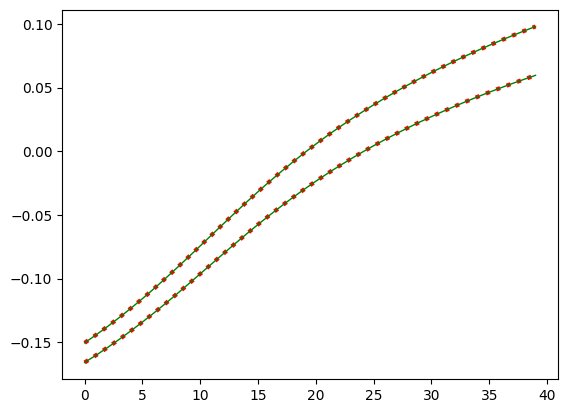

In [67]:
ev0 = np.zeros((len(evreals)))
ev1 = ev0.copy()
ev2 = ev0.copy()
ev3 = ev0.copy()

for i in range(len(evreals)):
    ev0[i] = evreals[i][0]
    ev1[i] = evreals[i][1]
    ev2[i] = evreals[i][2]
    ev3[i] = evreals[i][3]

plt.plot(ev0, linewidth=3, linestyle=":", color="red")
plt.plot(ev1, linewidth=1, color="green")
plt.plot(ev2, linewidth=3, linestyle=":", color="red")
plt.plot(ev3, linewidth=1, color="green")
plt.show()

In [55]:
di = 0.1
round = 6
round_comp = 4
limzero = 1e-4


for Eext in np.arange(emin, emax, di):
    print("Eext = ", Eext)
    for Iext in np.arange(imin, imax, di):
        
        key = str(np.around(Eext,1)) + ", " + str(np.around(Iext,1))

        #if np.abs(Eext) > limzero or np.abs(Iext) > limzero:
        #    continue

        #if state[key]["#stable"] is not None:
        #    continue

        nrand = 100
        roots_list = []

        for k in range(nrand):

            rinit = 0.5 * np.random.rand(4)

            roots = np.around(scipy.optimize.fsolve(WC2N, rinit, (Eext, Iext)),round)
            rinit = roots.copy()
            roots = np.around(scipy.optimize.fsolve(WC2N, rinit, (Eext, Iext)),round)

            if np.amax(WC2N(roots, Eext, Iext)) > limzero:
                continue

            append = True

            for r in roots_list:
                if (np.around(r[0],round_comp) == np.around(roots[0],round_comp)
                    and np.around(r[1],round_comp) == np.around(roots[1],round_comp)
                    and np.around(r[2],round_comp) == np.around(roots[2],round_comp)
                    and np.around(r[3],round_comp) == np.around(roots[3],round_comp)):
                    append = False
                    break

            if append:
                roots_list.append(roots)
        
        ev_list = []
        count_stable = 0
        count_unstable = 0

        for r in roots_list:
            jac = Jacobian(r, Eext, Iext)
            evs = np.linalg.eigvals(jac)

            if (evs.real < -limzero).all():
                count_stable += 1
            else:
                count_unstable += 1

        state[key]["#stable"] = count_stable
        state[key]["#unstable"] = count_unstable

Eext =  0.0


/home/lena/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/home/lena/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/tmp/ipykernel_8243/2702409607.py:12: RuntimeWarning: overflow encountered in exp
  return 1./(1. + np.exp(-a*(x-mu)))


Eext =  0.1
Eext =  0.2
Eext =  0.30000000000000004
Eext =  0.4
Eext =  0.5
Eext =  0.6000000000000001
Eext =  0.7000000000000001
Eext =  0.8
Eext =  0.9
Eext =  1.0
Eext =  1.1
Eext =  1.2000000000000002
Eext =  1.3
Eext =  1.4000000000000001
Eext =  1.5
Eext =  1.6
Eext =  1.7000000000000002
Eext =  1.8
Eext =  1.9000000000000001
Eext =  2.0
Eext =  2.1
Eext =  2.2
Eext =  2.3000000000000003
Eext =  2.4000000000000004
Eext =  2.5
Eext =  2.6
Eext =  2.7
Eext =  2.8000000000000003
Eext =  2.9000000000000004


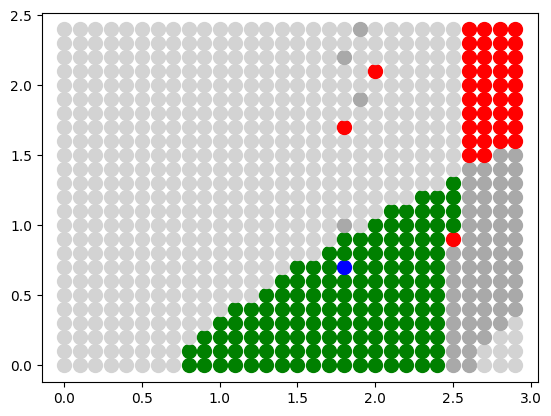

In [56]:
for Eext in np.arange(emin, emax, di):
    for Iext in np.arange(imin, imax, di):
        key = str(np.around(Eext,1)) + ", " + str(np.around(Iext,1))

        if state[key]["#stable"] is None: continue

        if state[key]["#stable"] == 1 and state[key]["#unstable"] == 0:
            col = "lightgrey"
        elif state[key]["#stable"] == 1:
            col= "darkgray"
        elif state[key]["#stable"] == 0 and state[key]["#unstable"] == 1:
            col = "green"
        elif state[key]["#stable"] > 1:
            col = "red"
        else: col = "blue"

        plt.plot(Eext, Iext, marker="o", color=col, markersize=10)

plt.show()

In [59]:
cmap = plt.cm.jet

eext, iext =  0.8 0.1
DIFFERENT PERIODS
eext, iext =  0.9 0.2
DIFFERENT PERIODS
eext, iext =  1.0 0.0
DIFFERENT PERIODS
eext, iext =  1.0 0.1
SAME PERIOD; SAME PHASES


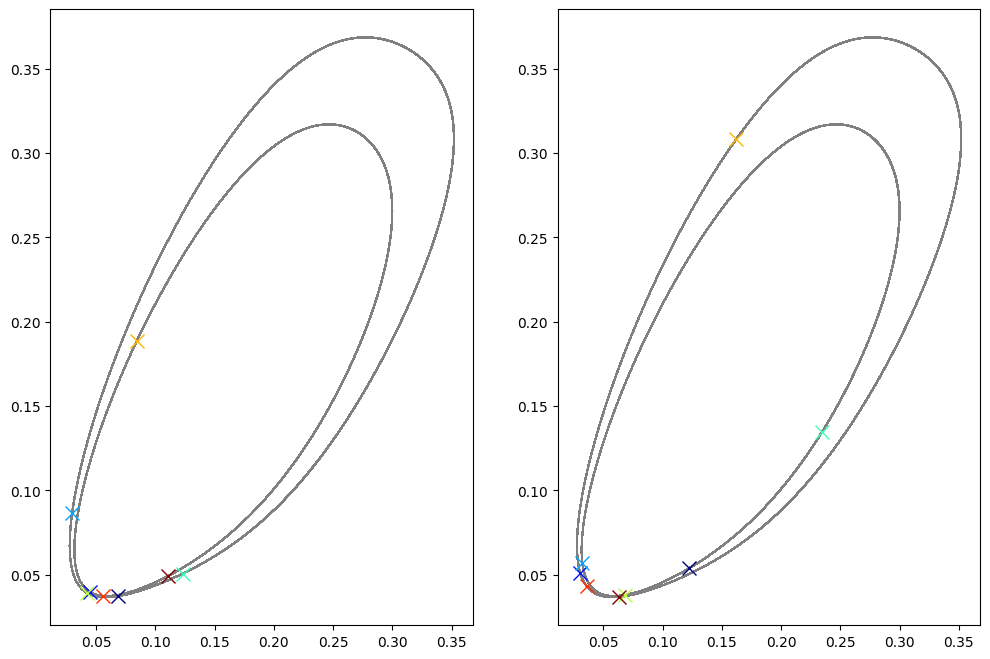

eext, iext =  1.0 0.2
DIFFERENT PERIODS
eext, iext =  1.0 0.3
DIFFERENT PERIODS
eext, iext =  1.1 0.0
DIFFERENT PERIODS
eext, iext =  1.1 0.1
DIFFERENT PERIODS
eext, iext =  1.1 0.2
DIFFERENT PERIODS
eext, iext =  1.1 0.3
DIFFERENT PERIODS
eext, iext =  1.2 0.1
DIFFERENT PERIODS
eext, iext =  1.2 0.2
DIFFERENT PERIODS
eext, iext =  1.2 0.3
DIFFERENT PERIODS
eext, iext =  1.2 0.4
DIFFERENT PERIODS
eext, iext =  1.2 0.5
DIFFERENT PERIODS
eext, iext =  1.3 0.0
DIFFERENT PERIODS
eext, iext =  1.3 0.1
DIFFERENT PERIODS
eext, iext =  1.3 0.2
DIFFERENT PERIODS
eext, iext =  1.3 0.3
DIFFERENT PERIODS
eext, iext =  1.3 0.4
DIFFERENT PERIODS
eext, iext =  1.3 0.5
DIFFERENT PERIODS
eext, iext =  1.4 0.0
DIFFERENT PERIODS
eext, iext =  1.4 0.1
DIFFERENT PERIODS
eext, iext =  1.4 0.2
DIFFERENT PERIODS
eext, iext =  1.4 0.3
SAME PERIOD; DIFFERENT PHASES
eext, iext =  1.4 0.4
DIFFERENT PERIODS
eext, iext =  1.4 0.5
DIFFERENT PERIODS
eext, iext =  1.4 0.6
DIFFERENT PERIODS
eext, iext =  1.5 0.1
DIFFER

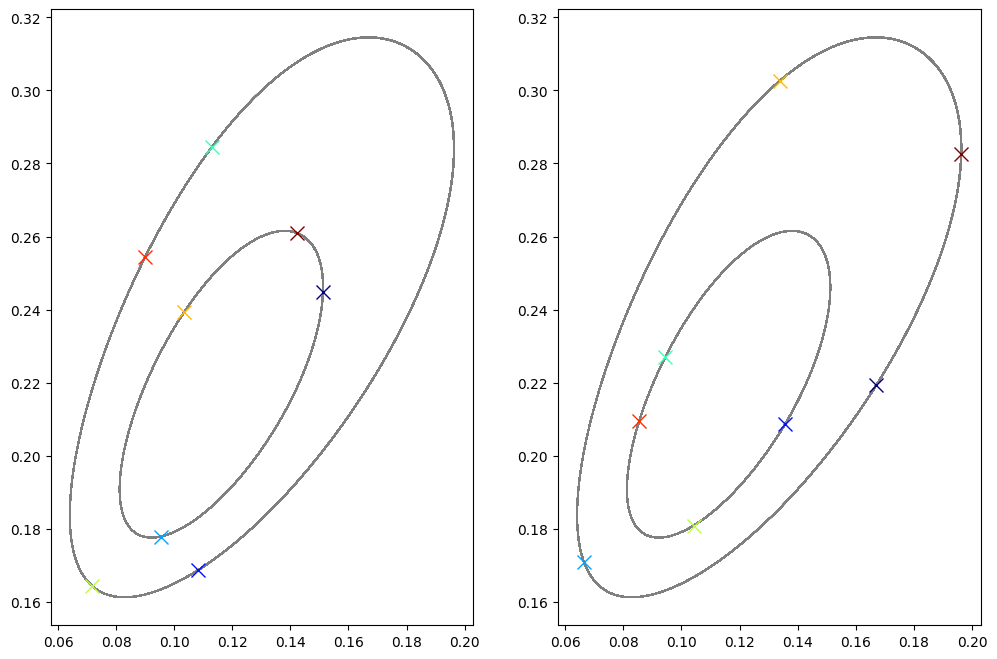

In [67]:
di = 0.1

simround = 1
zerolim = 1e-6

for Eext in np.arange(emin, emax, di):
    for Iext in np.arange(imin, imax, di):
        
        key = str(np.around(Eext,1)) + ", " + str(np.around(Iext,1))

        if state[key]["#osc"] is not None:
            if state[key]["#osc"] == 0:
                continue

        if state[key]["type"] is not None:
            if state[key]["type"] == "1osc in phase":
                continue

        print("eext, iext = ", np.around(Eext,1), np.around(Iext,1))

        wc = WCModel(Cmat=cmat, Dmat=np.zeros((2,2)))
        wc.params.exc_ext_baseline = Eext
        wc.params.inh_ext_baseline = Iext
        wc.params.duration = 5000.

        reps, tind = 60, 20000
        trajectory = np.zeros((reps, 4, tind))

        for k in range(reps):
            init = 0.5 * np.random.rand(4)
            wc.params.exc_init = np.array([[init[0]], [init[1]]])
            wc.params.inh_init = np.array([[init[2]], [init[3]]])
            wc.run()

            trajectory[k,0,:] = wc.exc[0,-tind:]
            trajectory[k,1,:] = wc.inh[0,-tind:]
            trajectory[k,2,:] = wc.exc[1,-tind:]
            trajectory[k,3,:] = wc.inh[1,-tind:]

        osc = False
        for k in range(reps):
            for j in range(4):
                if np.var(trajectory[k,j,:]) > zerolim:
                    osc = True

            if osc: break

        if not osc:
            state[key]["#osc"] = 0
            continue

        period_ind = np.zeros((reps))
        zero_dist_array = np.zeros((reps))
        zero_dist_array_0 = np.zeros((reps))
        zero_dist_array_1 = np.zeros((reps))
        for k in range(reps):
            euclidian_dist = np.zeros((tind))
            zero_dist = np.zeros((tind))
            zero_dist_0 = np.zeros((tind))
            zero_dist_1 = np.zeros((tind))
            for t in range(tind):
                euclidian_dist[t] = np.sqrt( (trajectory[k,0,t] - trajectory[k,0,0])**2 + 
                                    (trajectory[k,1,t] - trajectory[k,1,0])**2 + 
                                    (trajectory[k,2,t] - trajectory[k,2,0])**2 + 
                                    (trajectory[k,3,t] - trajectory[k,3,0])**2 )
                zero_dist[t] = np.sqrt( trajectory[k,0,t]**2 + trajectory[k,1,t]**2 + trajectory[k,2,t]**2 + trajectory[k,3,t]**2 )
                zero_dist_0[t] = np.sqrt( trajectory[k,0,t]**2 + trajectory[k,1,t]**2)
                zero_dist_1[t] = np.sqrt( trajectory[k,2,t]**2 + trajectory[k,3,t]**2)
                
            zero_dist_array[k] = np.around(np.amin(zero_dist),4)
            zero_dist_array_0[k] = np.around(np.amin(zero_dist_0),4)
            zero_dist_array_1[k] = np.around(np.amin(zero_dist_1),4)

            mins = scipy.signal.find_peaks(-euclidian_dist, prominence=0.01)[0]
            periods = []
            for mi in range(1, len(mins)):
                periods.append(mins[mi] - mins[mi-1])
            #print("periods = ", periods)
            if np.amax(periods) - np.amin(periods) > 1:
                print("WARNING: irregular oscillation---------------------------")
            period_ind[k] = np.mean(periods)          

        #print("return time = period = ", np.around(period_ind,2))
        #print("zero dist array = ", zero_dist_array)

        # all periods the same - are phases different?
        if np.amax(period_ind) - np.amin(period_ind) < 1:            
            if np.amax(zero_dist_array) - np.amin(zero_dist_array) < zerolim:
                print("SAME PERIOD; SAME PHASES")
                state[key]["#osc"] = 1

                ###### is osc out of phase?
                in_phase = []
                for k in range(reps):
                    dist = np.sqrt( (trajectory[k,0,-1] - trajectory[k,2,-1])**2 + (trajectory[k,1,-1] - trajectory[k,3,-1])**2)
                    if dist > 1e-3:
                        in_phase.append(False)
                    else:
                        in_phase.append(True)

                if in_phase.count(False) == 0:
                    state[key]["type"] = "1osc in phase"
                    continue

                fig, ax = plt.subplots(1,2, figsize=(12,8))
                for k in range(reps):
                    ax[0].plot(trajectory[k,0,:], trajectory[k,1,:], color="gray", linewidth=1)
                    ax[1].plot(trajectory[k,2,:], trajectory[k,3,:], color="gray", linewidth=1)

                crossnum = 8
                for k in range(crossnum):
                    ax[0].plot(trajectory[k,0,-1], trajectory[k,1,-1], color=cmap(k/(crossnum-1)), marker="x", markersize=10)
                    ax[1].plot(trajectory[k,2,-1], trajectory[k,3,-1], color=cmap(k/(crossnum-1)), marker="x", markersize=10)

                plt.show()
                continue
            else:
                print("SAME PERIOD; DIFFERENT PHASES")
                
        else:
            print("DIFFERENT PERIODS")


In [20]:
def func(x, *args):
    a = args
    return x+a

In [22]:
roots = scipy.optimize.fsolve(func, 0, args=2.)
print(roots)

[-2.]
